DATA LOADING

In [1]:
"""
CEOAE peak-picking algorithm

Author: havlajos
Created: 26/04/2023
Last Update: 07/07/2023

Description: Analysis of the phase-gradient delay of CEOAE data using the peak-picking algorithm.
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from gradient_delay import *
from peak_picking import *

# CEOAE data loading - CHOOSE !
FILENAME = "data/ceoae2/ceoae50g130R19rs20.mat"
mat_CEOAE = scipy.io.loadmat(FILENAME)

# ! CHANGE THE DICT KEYS !
fs = mat_CEOAE['fs'].flatten()  # sample rate
CEOAE = mat_CEOAE['click50'].flatten()  # CEOAE wave
time_axis = np.arange(0, np.size(CEOAE)/fs, 1/fs)

# we cut off spectrum because our reference is only at isolated frequencies - CHOOSE !
spectrum = np.fft.fft(CEOAE)
lower_freq, upper_freq = 200, 6000
fx = np.arange(len(spectrum))*fs/len(spectrum)
spectrum = spectrum[(fx >= lower_freq) & (fx <= upper_freq)]
fx = fx[(fx >= lower_freq) & (fx <= upper_freq)]

SPL = 20*np.log10(np.abs(spectrum))
SPL_array = [SPL]

for i in range(25, 30):
    # CEOAE data loading
    mat_CEOAE = scipy.io.loadmat(f"data/ceoae2/ceoae50g130R{i}rs20.mat")

    # ! CHANGE THE DICT KEYS !
    fs = mat_CEOAE['fs'].flatten()  # sample rate
    CEOAE = mat_CEOAE['click50'].flatten()  # CEOAE wave
    time_axis = np.arange(0, np.size(CEOAE)/fs, 1/fs)

    # we cut off spectrum because our reference is only at isolated frequencies
    spectrum = np.fft.fft(CEOAE)
    fx = np.arange(len(spectrum))*fs/len(spectrum)
    spectrum = spectrum[(fx >= lower_freq) & (fx <= upper_freq)]
    fx = fx[(fx >= lower_freq) & (fx <= upper_freq)]

    SPL = 20*np.log10(np.abs(spectrum))
    SPL_array.append(SPL)

grad_delay = calcDelay(fx, spectrum)

# peak picking
maximas_CEOAE = findLocalMaxima(SPL)
shift = 1  # 3 points around all peaks (the peak is included)
ext_maximas_CEOAE = peakNeighbours(maximas_CEOAE, shift, np.size(fx))


ISOINTENSITY (REFERENCE)

In [2]:
from isoint import *

ISOINT_start, ISOINT_stop, ISOINT_step = 1000, 3200, 200

freq_ISOINT_list = []
GD_ISOINT_list = []
max_idx_ISOINT_list = []

for i in range(ISOINT_start, ISOINT_stop + 1, ISOINT_step):
    filename = f"data/isointFT/isoint_{i}Hz_Level_20dB_TM45130.mat"
    freq_ISOINT, group_delay_ISOINT, max_idx_ISOINT = processIsoInt(filename)

    freq_ISOINT_list.append(freq_ISOINT)
    GD_ISOINT_list.append(group_delay_ISOINT)
    max_idx_ISOINT_list.append(max_idx_ISOINT)

# reference delay for 500 Hz
iso_500 = scipy.io.loadmat(
    "data/isointFT/isointTD_500Hz_sekce544Level_20dB_130TMres45OP0.mat")

fx_500 = iso_500['frekax'].flatten()
trans_fcn_500 = 20 * \
    np.log10(np.abs(iso_500['Ybm'].flatten()/iso_500['Yme'].flatten()))
max_500 = findGlobalMaximum(trans_fcn_500)

ph_500 = np.angle(iso_500['Ybm'].flatten()/iso_500['Yme'].flatten())
# grad_500 = (np.unwrap(ph_500)[max_500+1] - np.unwrap(ph_500)[max_500-1])/10
grad_500 = (np.unwrap(ph_500)[max_500+1] - np.unwrap(ph_500)[max_500-1]) / \
    (fx_500[max_500+1] - fx_500[max_500-1])
GD_500 = -grad_500/(2*np.pi)
GD_500 *= 2

# reference delay for 750 Hz
iso_750 = scipy.io.loadmat(
    "data/isointFT/isointTD_750Hz_sekce483Level_20dB_130TMres45OP0.mat")

fx_750 = iso_750['frekax'].flatten()
trans_fcn_750 = 20 * \
    np.log10(np.abs(iso_750['Ybm'].flatten()/iso_750['Yme'].flatten()))
max_750 = findGlobalMaximum(trans_fcn_750)

ph_750 = np.angle(iso_750['Ybm'].flatten()/iso_750['Yme'].flatten())
# grad_750 = (np.unwrap(ph_750)[max_750] - np.unwrap(ph_750)[max_750-2])/20
grad_750 = (np.unwrap(ph_750)[max_750+1] - np.unwrap(ph_750)[max_750-1]) / \
    (fx_750[max_750+1] - fx_750[max_750-1])
GD_750 = -grad_750/(2*np.pi)
GD_750 *= 2


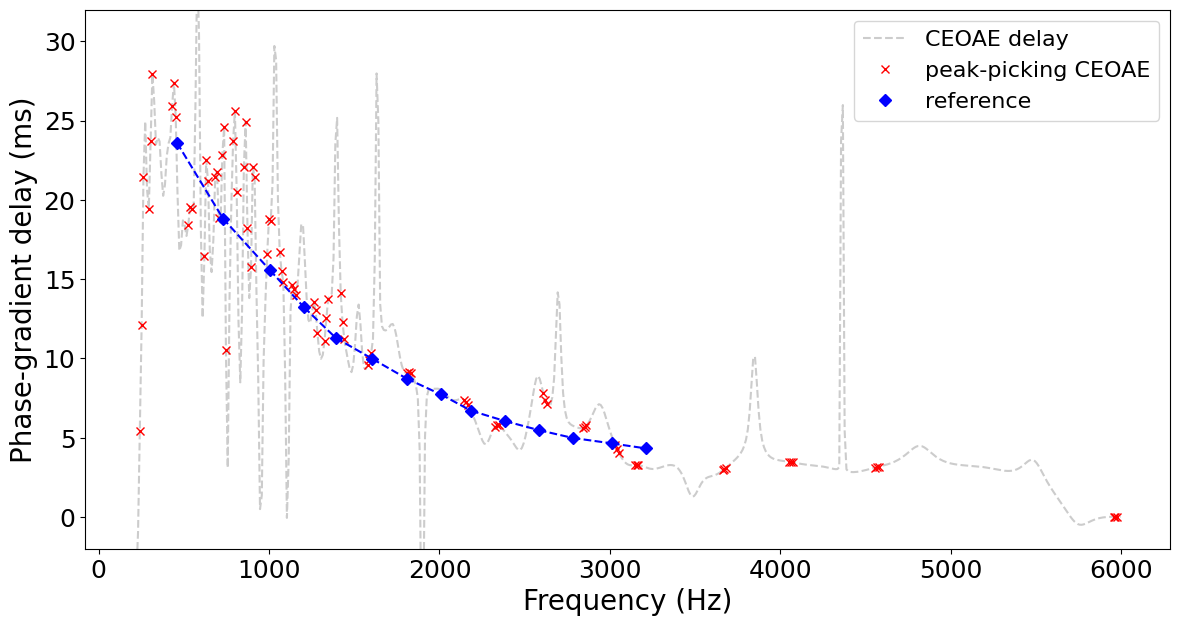

In [3]:
fig, ax = plt.subplots(figsize=(14, 7))

# multiplying by 1000 because of the transfer to miliseconds
ax.plot(fx, 1000*grad_delay, '0.8',
        linestyle='--', label='CEOAE delay')
ax.plot(fx[ext_maximas_CEOAE], 1000*grad_delay[ext_maximas_CEOAE],
        "rx", label='peak-picking CEOAE')

# reference values
for i, freq_ISOINT in enumerate(freq_ISOINT_list):
    max_idx = max_idx_ISOINT_list[i]
    grad_delay_ISOINT = GD_ISOINT_list[i]
    ax.plot(freq_ISOINT[max_idx], 1000*grad_delay_ISOINT[max_idx],
            "bD", label='reference' if i == 0 else None)
    if i > 0:  # connect points starting from the second point
        ax.plot([freq_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]], freq_ISOINT[max_idx]],
                [1000*GD_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]],
                    1000*grad_delay_ISOINT[max_idx]],
                "b--")
ax.plot(fx_500[max_500], 1000*GD_500, "bD")
ax.plot(fx_750[max_750], 1000*GD_750, "bD")

ax.plot([fx_500[max_500], fx_750[max_750], freq_ISOINT_list[0][max_idx_ISOINT_list[0]]],
        [1000*GD_500, 1000*GD_750, 1000*GD_ISOINT_list[0][max_idx_ISOINT_list[0]]], "b--")

ax.set_ylim([-2, 32])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel('Frequency (Hz)', fontdict={"fontsize": 20})
ax.set_ylabel('Phase-gradient delay (ms)', fontdict={"fontsize": 20})
ax.legend(fontsize=16)

plt.rcParams['font.family'] = 'Times New Roman'
#plt.savefig("peak_picking_CEOAE.png", dpi=300)
plt.show()
